<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125972 entries, 0 to 125971
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125972 non-null  int64  
 1   protocol_type                125972 non-null  object 
 2   service                      125972 non-null  object 
 3   flag                         125972 non-null  object 
 4   src_bytes                    125972 non-null  int64  
 5   dst_bytes                    125972 non-null  int64  
 6   land                         125972 non-null  int64  
 7   wrong_fragment               125972 non-null  int64  
 8   urgent                       125972 non-null  int64  
 9   hot                          125972 non-null  int64  
 10  num_failed_logins            125972 non-null  int64  
 11  logged_in                    125972 non-null  int64  
 12  num_compromised              125972 non-null  int64  
 13 

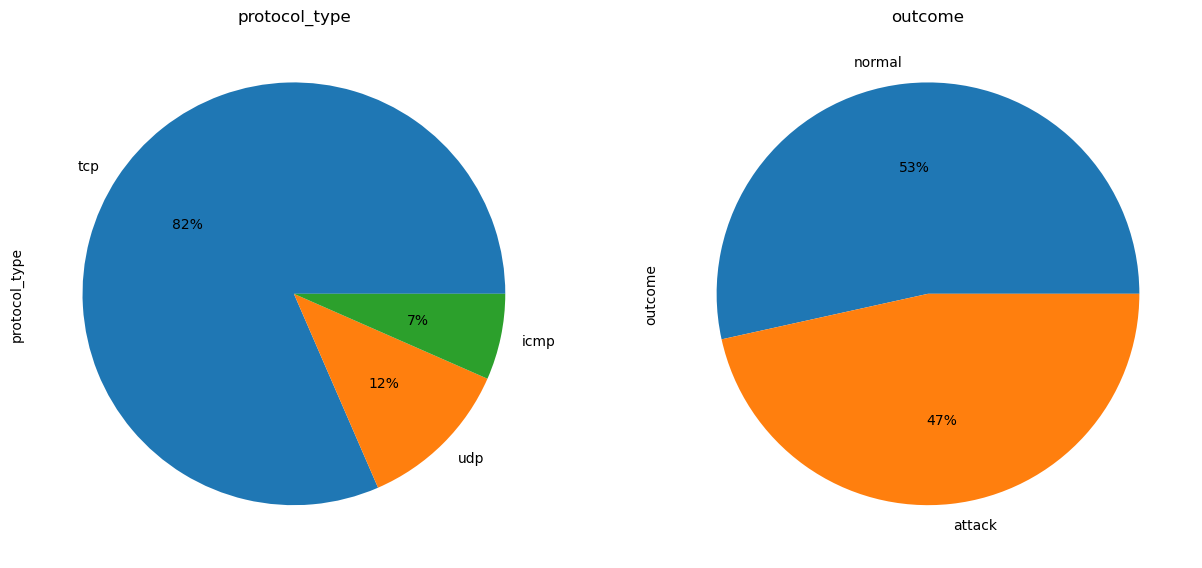

Number of original features is 122 and of reduced features is 20
Number of original features is 122 and of reduced features is 20


In [2]:
# Importation des bibliothèques nécessaires
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import regularizers
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics

# Configuration des options d'affichage
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
%matplotlib inline

# Exploration du jeu de données
# Lecture des ensembles de données d'entraînement et de test à partir d'un fichier CSV
data_train = pd.read_csv("../input/nslkdd/KDDTrain+.txt")

# Affichage des premières lignes du jeu de données d'entraînement
data_train.head()

# Définition des noms de colonnes
columns = (['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
            'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
            'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate',
            'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
            'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
            'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'outcome', 'level'])

# Attribution des noms de colonnes au jeu de données
data_train.columns = columns

# Affichage des informations sur le jeu de données d'entraînement
data_train.info()

# Affichage des statistiques descriptives du jeu de données d'entraînement
data_train.describe().style.background_gradient(cmap='Blues').set_properties(**{'font-family': 'Segoe UI'})

# Modification de la valeur de la colonne "outcome" pour regrouper les données en attaque ou normales
data_train.loc[data_train['outcome'] != 'normal', "outcome"] = 'attack'

# Fonction pour tracer des diagrammes circulaires pour les colonnes spécifiées
def pie_plot(df, cols_list, rows, cols):
    fig, axes = plt.subplots(rows, cols)
    for ax, col in zip(axes.ravel(), cols_list):
        df[col].value_counts().plot(ax=ax, kind='pie', figsize=(15, 15), fontsize=10, autopct='%1.0f%%')
        ax.set_title(str(col), fontsize=12)
    plt.show()

# Tracé des diagrammes circulaires pour les colonnes 'protocol_type' et 'outcome'
pie_plot(data_train, ['protocol_type', 'outcome'], 1, 2)

# Prétraitement des données
# Fonction pour mettre à l'échelle les colonnes numériques
def Scaling(df_num, cols):
    std_scaler = RobustScaler()
    std_scaler_temp = std_scaler.fit_transform(df_num)
    std_df = pd.DataFrame(std_scaler_temp, columns=cols)
    return std_df

# Colonnes catégorielles
cat_cols = ['is_host_login', 'protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_guest_login', 'level', 'outcome']

# Fonction de prétraitement des données
def preprocess(dataframe):
    df_num = dataframe.drop(cat_cols, axis=1)
    num_cols = df_num.columns
    scaled_df = Scaling(df_num, num_cols)

    dataframe.drop(labels=num_cols, axis="columns", inplace=True)
    dataframe[num_cols] = scaled_df[num_cols]

    dataframe.loc[dataframe['outcome'] == "normal", "outcome"] = 0
    dataframe.loc[dataframe['outcome'] != 0, "outcome"] = 1

    dataframe = pd.get_dummies(dataframe, columns=['protocol_type', 'service', 'flag'])
    return dataframe

# Prétraitement du jeu de données d'entraînement
scaled_train = preprocess(data_train)

# Séparation des caractéristiques (features) et des étiquettes (labels)
x = scaled_train.drop(['outcome', 'level'], axis=1).values
y = scaled_train['outcome'].values
y_reg = scaled_train['level'].values

# Réduction de dimension avec PCA
pca = PCA(n_components=20)
pca = pca.fit(x)
x_reduced = pca.transform(x)
print("Number of original features is {} and of reduced features is {}".format(x.shape[1], x_reduced.shape[1]))

# Conversion des étiquettes en entiers
y = y.astype('int')

# Séparation des données d'entraînement et de test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train_reduced, x_test_reduced, y_train_reduced, y_test_reduced = train_test_split(x_reduced, y, test_size=0.2, random_state=42)
x_train_reg, x_test_reg, y_train_reg, y_test_reg = train_test_split(x, y_reg, test_size=0.2, random_state=42)
print("Number of original features is {} and of reduced features is {}".format(x.shape[1], x_reduced.shape[1]))

# Dictionnaire pour stocker les évaluations des modèles
kernal_evals = dict()

# Fonction pour évaluer les modèles de classification
def evaluate_classification(model, name, X_train, X_test, y_train, y_test):
    train_accuracy = metrics.accuracy_score(y_train, model.predict(X_train))
    test_accuracy = metrics.accuracy_score(y_test, model.predict(X_test))
    
    train_precision = metrics.precision_score(y_train, model.predict(X_train))
    test_precision = metrics.precision_score(y_test, model.predict(X_test))
    
    train_recall = metrics.recall_score(y_train, model.predict(X_train))
    test_recall = metrics.recall_score(y_test, model.predict(X_test))
    
    kernal_evals[str(name)] = [train_accuracy, test_accuracy, train_precision, test_precision, train_recall, test_recall]
    print("Training Accuracy " + str(name) + " {}  Test Accuracy ".format(train_accuracy * 100) + str(name) + " {}".format(test_accuracy * 100))
    print("Training Precesion " + str(name) + " {}  Test Precesion ".format(train_precision * 100) + str(name) + " {}".format(test_precision * 100))
    print("Training Recall " + str(name) + " {}  Test Recall ".format(train_recall * 100) + str(name) + " {}".format(test_recall * 100))
    
    actual = y_test
    predicted = model.predict(X_test)
    confusion_matrix = metrics.confusion_matrix(actual, predicted)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=['normal', 'attack'])

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.grid(False)
    cm_display.plot(ax=ax)


Training Accuracy KNeighborsClassifier 99.05236313841452  Test Accuracy KNeighborsClassifier 98.93629688430245
Training Precesion KNeighborsClassifier 99.22512234910276  Test Precesion KNeighborsClassifier 99.05636317266003
Training Recall KNeighborsClassifier 98.73133850195424  Test Recall KNeighborsClassifier 98.67050554661698


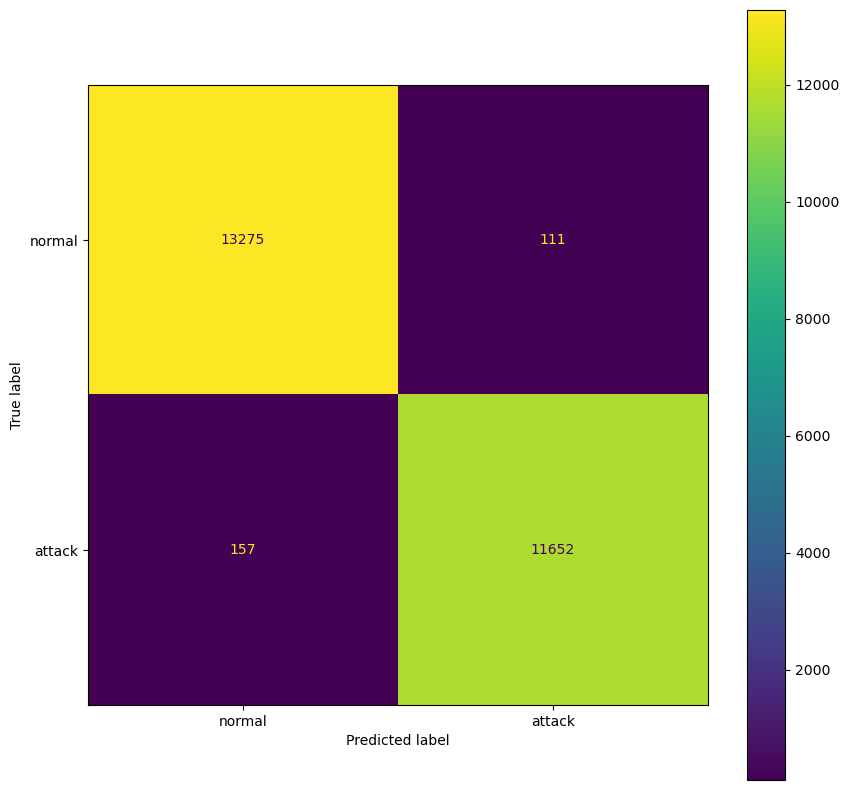

In [3]:
# Création d'un modèle KNeighborsClassifier avec 20 voisins
knn = KNeighborsClassifier(n_neighbors=20).fit(x_train, y_train)

# Évaluation du modèle KNeighborsClassifier
evaluate_classification(knn, "KNeighborsClassifier", x_train, x_test, y_train, y_test)


In [4]:
from sklearn.neighbors import KNeighborsClassifier

# Création d'une instance du modèle KNeighborsClassifier
knn_model = KNeighborsClassifier()

# Affichage des paramètres du modèle
print("Paramètres du modèle KNeighborsClassifier:")
print(knn_model.get_params())


Paramètres du modèle KNeighborsClassifier:
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
